# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.2.0', '4.45.0', '2.2.0+cu121')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [ ]:
import datasets

### Load Dataset

raw_datasets = datasets.load_dataset("OxAISH-AL-LLM/wiki_toxic")

In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})

In [6]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'non': 0, 'tox': 1}

In [7]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'non', 1: 'tox'}

## 2. Model & Tokenization

In [8]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

2

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

/home/jupyter-st124846/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing 

In [10]:
def tokenize_function(examples):
    result = tokenizer(examples["comment_text"], max_length=128, truncation=True)
    return result

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25868
    })
})

In [12]:
# Remove columns: 'comment_text' and 'id'
tokenized_datasets = tokenized_datasets.remove_columns(["comment_text", "id"])

# Rename column: 'label' to 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25868
    })
})

In [13]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 1998, 2008, 1005, 1055, 2025, 1037, 3167, 2886, 1034, 1034, 1029,
         102])

In [14]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] and that's not a personal attack ^ ^? [SEP]"

## 4. Preparing the dataloader

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [16]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(50000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))

In [17]:
small_train_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 50000
})

In [18]:
small_eval_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [19]:
small_test_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [20]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [21]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [22]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non",
    "1": "tox"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non": 0,
    "tox": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [23]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [24]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [25]:
# Create uninitialized student model
student_model = type(teacher_model)(configuration)
student_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [26]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

# Function to distill weights for odd or even layers
def distill_bert_weights(teacher: nn.Module, student: nn.Module, odd_layers=True) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, odd_layers)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            if odd_layers:
                # Odd layers: 1, 3, 5, 7, 9, 11 (0-indexed: 0, 2, 4, 6, 8, 10)
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2 * i].state_dict())
            else:
                # Even layers: 2, 4, 6, 8, 10, 12 (0-indexed: 1, 3, 5, 7, 9, 11)
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2 * i + 1].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student_model

In [27]:
student_model = distill_bert_weights(teacher=teacher_model, student=student_model, odd_layers=True)
student_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(student_model))

Teacher parameters : 109483778
Student parameters : 66956546


In [29]:
count_parameters(student_model)/count_parameters(teacher_model) * 100

61.156590705154514

In [30]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [31]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [32]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [33]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=student_model.parameters(), lr=lr)

In [34]:
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [35]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [36]:
# !pip install evaluate

In [37]:
import numpy as np
import evaluate
# Get the metric function
metric = evaluate.load("accuracy")

## 9. Train

In [38]:
# Function to train and evaluate a model
def train_and_evaluate(student_model, teacher_model, train_dataloader, eval_dataloader, optimizer, lr_scheduler, num_epochs, device):
    progress_bar = tqdm(range(num_training_steps))
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_metrics = 0

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # Compute student output
            outputs = student_model(**batch) 
            # Compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # Classification loss  
            loss_cls = outputs.loss
            train_loss_cls += loss_cls.item()
            # Distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # Cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            # Average the loss
            loss = (loss_cls + loss_div + loss_cos) / 3

            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        # Save training losses
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        # Evaluation
        student_model.eval()
        eval_loss = 0
        predictions, labels = [], []
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            metric.add_batch(predictions=predictions, references=batch["labels"])
        
        # Compute evaluation metrics
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_dataloader):.4f}, Eval Loss = {eval_loss / len(eval_dataloader):.4f}, Accuracy = {eval_metric['accuracy']:.4f}")
        print(f"  - Loss_cls: {train_loss_cls / len(train_dataloader):.4f}")
        print(f"  - Loss_div: {train_loss_div / len(train_dataloader):.4f}")
        print(f"  - Loss_cos: {train_loss_cos / len(train_dataloader):.4f}")

    # Return average training loss, test accuracy, and loss lists
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_accuracy = eval_metrics / num_epochs
    return avg_train_loss, avg_test_accuracy, train_losses, train_losses_cls, train_losses_div, train_losses_cos, eval_losses

In [39]:
# Train and evaluate Odd Layer model
print("Training Odd Layer Model...")
odd_layer_model = distill_bert_weights(teacher=teacher_model, student=student_model, odd_layers=True)
odd_avg_train_loss, odd_avg_test_accuracy, odd_train_losses, odd_train_losses_cls, odd_train_losses_div, odd_train_losses_cos, odd_eval_losses = train_and_evaluate(
    student_model=odd_layer_model,
    teacher_model=teacher_model,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=num_epochs,
    device=device
)

Training Odd Layer Model...


  0%|          | 0/7815 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.1938, Eval Loss = 0.3521, Accuracy = 0.9550
  - Loss_cls: 0.3775
  - Loss_div: 0.1291
  - Loss_cos: 0.0749
Epoch 2: Train Loss = 0.1861, Eval Loss = 0.3797, Accuracy = 0.9440
  - Loss_cls: 0.3497
  - Loss_div: 0.1394
  - Loss_cos: 0.0691
Epoch 3: Train Loss = 0.1819, Eval Loss = 0.3626, Accuracy = 0.9570
  - Loss_cls: 0.3335
  - Loss_div: 0.1446
  - Loss_cos: 0.0676
Epoch 4: Train Loss = 0.1798, Eval Loss = 0.3564, Accuracy = 0.9580
  - Loss_cls: 0.3258
  - Loss_div: 0.1470
  - Loss_cos: 0.0665
Epoch 5: Train Loss = 0.1787, Eval Loss = 0.3528, Accuracy = 0.9600
  - Loss_cls: 0.3222
  - Loss_div: 0.1482
  - Loss_cos: 0.0659


In [40]:
# Train and evaluate Even Layer model
print("Training Even Layer Model...")
even_layer_model = distill_bert_weights(teacher=teacher_model, student=student_model, odd_layers=False)
even_avg_train_loss, even_avg_test_accuracy, even_train_losses, even_train_losses_cls, even_train_losses_div, even_train_losses_cos, even_eval_losses = train_and_evaluate(
    student_model=even_layer_model,
    teacher_model=teacher_model,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=num_epochs,
    device=device
)

Training Even Layer Model...


  0%|          | 0/7815 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4167, Eval Loss = 0.8330, Accuracy = 0.1160
  - Loss_cls: 0.8498
  - Loss_div: 0.0117
  - Loss_cos: 0.3886
Epoch 2: Train Loss = 0.4169, Eval Loss = 0.8330, Accuracy = 0.1160
  - Loss_cls: 0.8498
  - Loss_div: 0.0116
  - Loss_cos: 0.3893
Epoch 3: Train Loss = 0.4167, Eval Loss = 0.8330, Accuracy = 0.1160
  - Loss_cls: 0.8493
  - Loss_div: 0.0116
  - Loss_cos: 0.3893
Epoch 4: Train Loss = 0.4179, Eval Loss = 0.8330, Accuracy = 0.1160
  - Loss_cls: 0.8508
  - Loss_div: 0.0118
  - Loss_cos: 0.3911
Epoch 5: Train Loss = 0.4165, Eval Loss = 0.8330, Accuracy = 0.1160
  - Loss_cls: 0.8497
  - Loss_div: 0.0116
  - Loss_cos: 0.3882


In [41]:
# Print results
print("Model Type | Avg. Training Loss | Avg. Test Set Performance")
print(f"Odd Layer | {odd_avg_train_loss:.4f} | {odd_avg_test_accuracy:.4f}")
print(f"Even Layer | {even_avg_train_loss:.4f} | {even_avg_test_accuracy:.4f}")

Model Type | Avg. Training Loss | Avg. Test Set Performance
Odd Layer | 0.1841 | 0.9548
Even Layer | 0.4169 | 0.1160


In [42]:
# Plot losses
import matplotlib.pyplot as plt

# Function to plot losses
def plot_losses(epochs_list, train_losses, train_losses_cls, train_losses_div, 
                train_losses_cos, eval_losses, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label=f'{model_type} Train Loss')
    plt.plot(epochs_list, train_losses_cls, label=f'{model_type} Train Loss (Cls)')
    plt.plot(epochs_list, train_losses_div, label=f'{model_type} Train Loss (Div)')
    plt.plot(epochs_list, train_losses_cos, label=f'{model_type} Train Loss (Cos)')
    plt.plot(epochs_list, eval_losses, label=f'{model_type} Validation Loss')
    plt.title(f'{model_type} Model: Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

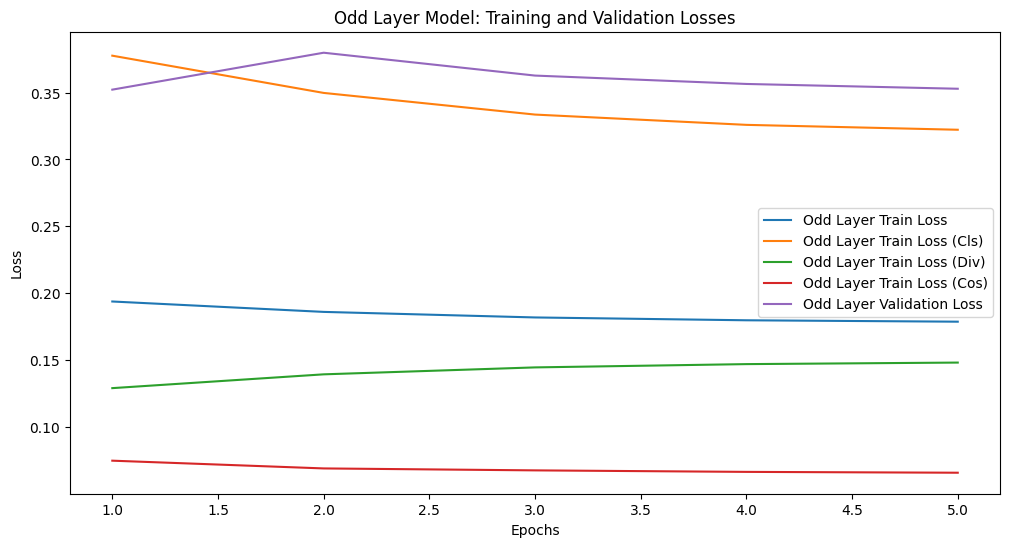

In [43]:
# Plot losses for Odd Layer model
epochs_list = range(1, num_epochs + 1)
plot_losses(epochs_list, odd_train_losses, odd_train_losses_cls, odd_train_losses_div, 
            odd_train_losses_cos, odd_eval_losses, "Odd Layer")

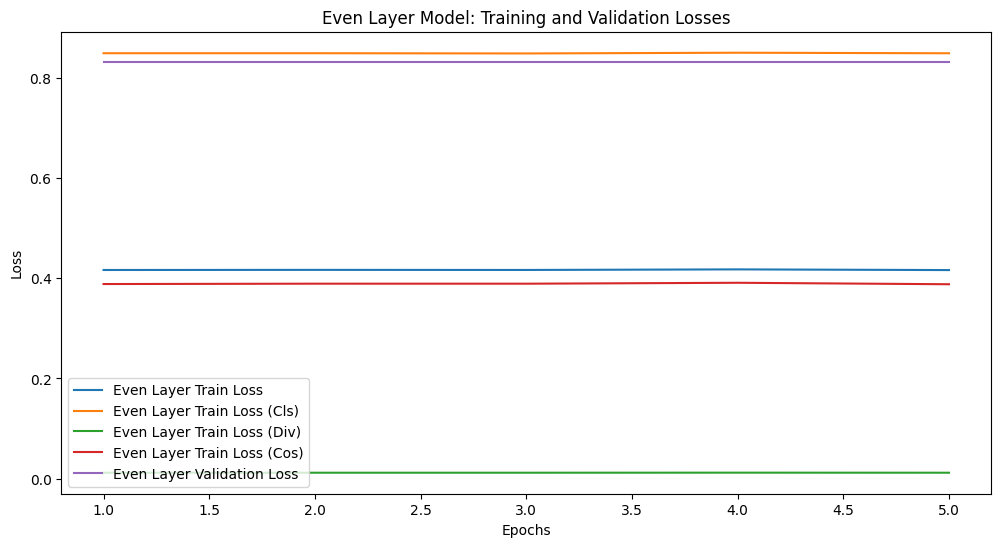

In [44]:
# Plot losses for Even Layer model
plot_losses(epochs_list, even_train_losses, even_train_losses_cls, even_train_losses_div, 
            even_train_losses_cos, even_eval_losses, "Even Layer")

### Appendix (Teacher Model)

In [45]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/7815 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1116:
Epoch at 1: Test Acc 0.9590
Epoch at 2: Train loss 0.0683:
Epoch at 2: Test Acc 0.9590
Epoch at 3: Train loss 0.0383:
Epoch at 3: Test Acc 0.9450
Epoch at 4: Train loss 0.0259:
Epoch at 4: Test Acc 0.9560
Epoch at 5: Train loss 0.0292:
Epoch at 5: Test Acc 0.9390
Avg Metric 0.9516


In [ ]:
# Save the trained model and tokenizer - Odd layer
odd_layer_model.save_pretrained("models_2/odd_layer_model")
tokenizer.save_pretrained("models_2/odd_layer_model")

('models_2/odd_layer_model/tokenizer_config.json',
 'models_2/odd_layer_model/special_tokens_map.json',
 'models_2/odd_layer_model/vocab.txt',
 'models_2/odd_layer_model/added_tokens.json',
 'models_2/odd_layer_model/tokenizer.json')

In [ ]:
# Save the trained model and tokenizer - Even layer
even_layer_model.save_pretrained("models_2/even_layer_model")
tokenizer.save_pretrained("models_2/even_layer_model")

('models_2/even_layer_model/tokenizer_config.json',
 'models_2/even_layer_model/special_tokens_map.json',
 'models_2/even_layer_model/vocab.txt',
 'models_2/even_layer_model/added_tokens.json',
 'models_2/even_layer_model/tokenizer.json')

### Implement LoRA

In [47]:
# !pip install peft
# !pip show accelerate - 1.5.2
# !pip show peft - 0.15.0

In [48]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model

# Define LoRA configuration and apply it to the student model
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    inference_mode=False, 
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1  # Dropout rate
)

lora_student_model = get_peft_model(student_model, peft_config)
lora_student_model.print_trainable_parameters()

lora_student_model = lora_student_model.to(device)

trainable params: 148,994 || all params: 67,105,540 || trainable%: 0.2220


In [49]:
# training hyperparameters
lora_optimizer = optim.Adam(params=lora_student_model.parameters(), lr=lr)

lora_lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=lora_optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [50]:
# Train and evaluate LoRA model
print("Training LoRA Model...")
lora_avg_train_loss, lora_avg_test_accuracy, lora_train_losses, lora_train_losses_cls, lora_train_losses_div, lora_train_losses_cos, lora_eval_losses = train_and_evaluate(
    student_model=lora_student_model,
    teacher_model=teacher_model,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    optimizer=lora_optimizer,
    lr_scheduler=lora_lr_scheduler,
    num_epochs=num_epochs,
    device=device
)

Training LoRA Model...


  0%|          | 0/7815 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.1907, Eval Loss = 0.1463, Accuracy = 0.9420
  - Loss_cls: 0.2017
  - Loss_div: 0.1939
  - Loss_cos: 0.1764
Epoch 2: Train Loss = 0.1194, Eval Loss = 0.1383, Accuracy = 0.9440
  - Loss_cls: 0.1282
  - Loss_div: 0.1200
  - Loss_cos: 0.1101
Epoch 3: Train Loss = 0.1131, Eval Loss = 0.1251, Accuracy = 0.9480
  - Loss_cls: 0.1215
  - Loss_div: 0.1136
  - Loss_cos: 0.1042
Epoch 4: Train Loss = 0.1090, Eval Loss = 0.1230, Accuracy = 0.9510
  - Loss_cls: 0.1178
  - Loss_div: 0.1089
  - Loss_cos: 0.1003
Epoch 5: Train Loss = 0.1072, Eval Loss = 0.1211, Accuracy = 0.9510
  - Loss_cls: 0.1153
  - Loss_div: 0.1068
  - Loss_cos: 0.0993


In [ ]:
# Print result
print(f"LoRA | {lora_avg_train_loss:.4f} | {lora_avg_test_accuracy:.4f}")

LoRA | 0.1279 | 0.9472


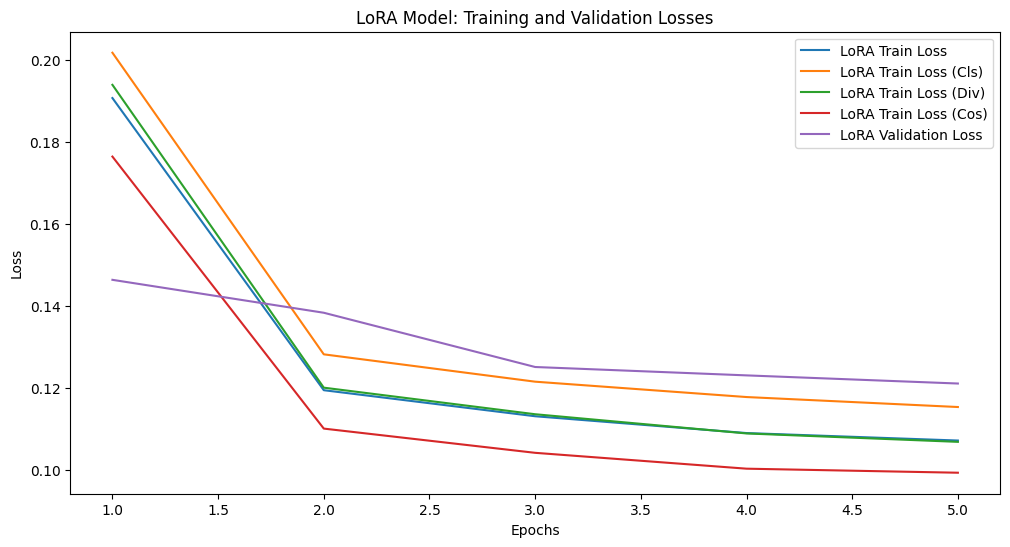

In [52]:
# Plot losses for LoRA model
plot_losses(epochs_list, lora_train_losses, lora_train_losses_cls, lora_train_losses_div, 
            lora_train_losses_cos, lora_eval_losses, "LoRA")

In [ ]:
# Save the trained model and tokenizer - LoRA

lora_student_model.save_pretrained("models_2/lora_model")
tokenizer.save_pretrained("models_2/lora_model")

('models_2/lora_model/tokenizer_config.json',
 'models_2/lora_model/special_tokens_map.json',
 'models_2/lora_model/vocab.txt',
 'models_2/lora_model/added_tokens.json',
 'models_2/lora_model/tokenizer.json')

### Inference

In [54]:
from transformers import AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
odd_layer_model = odd_layer_model.to(device)

# Function to classify text
def classify_toxicity(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    odd_layer_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = odd_layer_model(**inputs)
        logits = outputs.logits

    # Convert logits to class label
    predicted_class = torch.argmax(logits, dim=-1).item()  # Get the predicted class index
    label = "toxic" if predicted_class == 1 else "non-toxic"  # Depend on the dataset

    return label

# Example input
text = "I hate you"
result = classify_toxicity(text)
print(f"Text: '{text}' is classified as: {result}")

Text: 'I hate you' is classified as: toxic


In [56]:
from transformers import AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
odd_layer_model = odd_layer_model.to(device)

# Function to classify text
def classify_toxicity(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    odd_layer_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = odd_layer_model(**inputs)
        logits = outputs.logits

    # Convert logits to class label
    predicted_class = torch.argmax(logits, dim=-1).item()  # Get the predicted class index
    label = "toxic" if predicted_class == 1 else "non-toxic"  # Depend on the dataset

    return label

# Example input
text = "I love you"
result = classify_toxicity(text)
print(f"Text: '{text}' is classified as: {result}")

Text: 'I love you' is classified as: non-toxic
